Describe an algorithm that compares 2 images - one with few stars and one with many stars
The algorithm matches each star in the small image to its corresponding star in the large image.

- Inputs:
    img_S: sparse image
    img_L: dense image
    X: The number of stars to use for alignment (e.g., 2 or 3).

- Algorithm:
    S ← A list of coordinates of stars in the sparse image and their radius and brightness (x,y,r,b).
    L ← A list of coordinates of stars in the dense image their radius and brightness. (|L| > |S|).
    1) bright_s ← 5 brightest stars of S

    2) Generate Subsets:
        Iterate over all combinations of X stars from bright_s — denote each as S_X.
        For each S_X, iterate over all combinations of X stars from L — denote each as L_X.

    3) Compute Transformation:
        For each pair (S_X, L_X):
        Estimate a geometric transformation (e.g., scaling + translation) that maps S_X onto L_X.
        Apply this transformation to all stars in S, resulting in a transformed set S'.
    4) Evaluate Fit:
        For each star in S', check if there is a nearby star in L (within some small threshold distance ε).
        Count the number of unmatched stars (stars in S' with no close counterpart in L).
    5) Select Best Match:
        Keep track of the transformation with the fewest unmatched stars.
        Return this transformation (and optionally, the matching star pairs).

    6) Output:
        - The best matching transformation from the sparse image to the dense one.
        - The minimal number of unmatched stars.
        - Optionally, the list of matched star pairs.




In [1]:
import numpy as np
from itertools import combinations
from scipy.spatial.distance import cdist
from sqlalchemy import false

from process_star_img import detect_stars

import numpy as np
from itertools import combinations
from scipy.spatial.distance import cdist
import random

def compute_similarity_transform(src, dst):
    src = np.array(src)
    dst = np.array(dst)

    src_mean = np.mean(src, axis=0)
    dst_mean = np.mean(dst, axis=0)

    src_centered = src - src_mean
    dst_centered = dst - dst_mean

    U, S, Vt = np.linalg.svd(np.dot(dst_centered.T, src_centered))
    R = np.dot(U, Vt)

    scale = np.trace(np.dot(dst_centered.T, np.dot(R, src_centered))) / np.sum(src_centered ** 2)
    translation = dst_mean - scale * np.dot(src_mean, R.T)

    return scale, R, translation

def compute_exact_similarity_transform(src, dst):
    """
    Assumes src and dst each contain exactly 2 points.
    Returns scale, rotation matrix R, and translation vector t.
    """
    src = np.array(src)
    dst = np.array(dst)

    # Compute scale
    dist_src = np.linalg.norm(src[1] - src[0])
    dist_dst = np.linalg.norm(dst[1] - dst[0])
    scale = dist_dst / dist_src

    # Compute rotation
    vec_src = (src[1] - src[0]) / dist_src
    vec_dst = (dst[1] - dst[0]) / dist_dst

    angle = np.arctan2(vec_dst[1], vec_dst[0]) - np.arctan2(vec_src[1], vec_src[0])
    cos_a, sin_a = np.cos(angle), np.sin(angle)
    R = np.array([[cos_a, -sin_a], [sin_a, cos_a]])

    # Compute translation
    rotated_scaled_src0 = scale * np.dot(R, src[0])
    translation = dst[0] - rotated_scaled_src0

    return scale, R, translation


def apply_transform(points, scale, rotation, translation, scale_radius=False):
    points = np.array(points)
    transformed = points.copy()
    transformed[:, 0:2] = scale * np.dot(points[:, 0:2], rotation.T) + translation
    if scale_radius:
        transformed[:, 2] = scale * points[:, 2]
    return transformed

def match_stars(sparse_path, dense_path, X=2, epsilon=2.0, max_dense_combinations=2000, max_sparse_combinations=50):
    sparse = detect_stars(sparse_path)
    dense = detect_stars(dense_path)
    sparse = np.array(sparse)
    dense = np.array(dense)

    print("num of stars in sparse:", len(sparse))
    print("num of stars in dense:", len(dense))

    # Keep the brightest stars
    sparse = sorted(sparse, key=lambda s: s[2], reverse=True)[:15]
    sparse = np.array(sparse)

    best_mismatch = float('inf')
    best_transform = None
    best_matches = []

    # Sample sparse combinations
    sparse_combos = list(combinations(range(len(sparse)), X))
    if len(sparse_combos) > max_sparse_combinations:
        random.seed(0)
        sparse_combos = random.sample(sparse_combos, max_sparse_combinations)

    # Sample dense combinations
    dense_indices = list(range(len(dense)))
    if len(dense) >= X:
        random.seed(1)
        dense_combos = [tuple(random.sample(dense_indices, X)) for _ in range(min(max_dense_combinations, 2000))]
    else:
        dense_combos = list(combinations(dense_indices, X))

    dense_xy = dense[:, :2]

    for s_idx in sparse_combos:
        S_X = sparse[list(s_idx), 0:2]

        for d_idx in dense_combos:
            L_X = dense[list(d_idx), 0:2]

            scale, R, translation = compute_exact_similarity_transform(S_X, L_X)
            if scale is None:
                continue

            # Rough match on top 10 sparse stars before full transform
            partial_sparse = sparse[:10]
            partial_transformed = apply_transform(partial_sparse, scale, R, translation, scale_radius=True)
            partial_dists = cdist(dense_xy, partial_transformed[:, :2])
            rough_mismatch = np.sum(np.min(partial_dists, axis=1) > epsilon)

            if rough_mismatch > best_mismatch:
                continue

            transformed_sparse = apply_transform(sparse, scale, R, translation, scale_radius=True)
            transformed_xy = transformed_sparse[:, :2]

            dists = cdist(dense_xy, transformed_xy)
            min_dists = np.min(dists, axis=1)
            argmins = np.argmin(dists, axis=1)

            matches = []
            mismatches = 0
            for i, dist in enumerate(min_dists):
                if dist <= epsilon:
                    matches.append((dense[i][:2].tolist(), transformed_sparse[argmins[i]][:2].tolist()))
                else:
                    mismatches += 1

            if mismatches < best_mismatch:
                best_mismatch = mismatches
                best_transform = (scale, R, translation)
                best_matches = matches

                if mismatches == 0:
                    return best_transform, best_mismatch, best_matches

    return best_transform, best_mismatch, best_matches



In [2]:

first_img_path = "stars pics/fr1.jpg"
second_img_path = "stars pics/ST_db1.png"
first_img_codrs = detect_stars(first_img_path)
second_img_cords = detect_stars(second_img_path)

In [3]:
from pprint import pprint

transform, mismatches, matches = match_stars(first_img_path,second_img_path, X=2, epsilon=30.0)

print("Best Scale:", transform[0])
print("Best Translation:", transform[1])
print("Unmatched Stars:", mismatches)
print("Matches:")
for pair in matches:
    print(f"  Sparse star {pair[0]} matched to Dense star {pair[1]}")


num of stars in sparse: 20
num of stars in dense: 24
Best Scale: 0.4797920416094764
Best Translation: [[ 0.99555409 -0.09419162]
 [ 0.09419162  0.99555409]]
Unmatched Stars: 17
Matches:
  Sparse star [478.0, 924.0] matched to Dense star [478.0, 924.0]
  Sparse star [1044.5, 678.0] matched to Dense star [1057.7313488888954, 687.5201758800547]
  Sparse star [991.0, 560.0] matched to Dense star [990.9999999999999, 560.0]
  Sparse star [912.5, 422.125] matched to Dense star [901.5381106421106, 418.03990202381306]
  Sparse star [963.3636474609375, 299.2727355957031] matched to Dense star [944.9733127612047, 301.4124124840264]
  Sparse star [658.0, 262.0] matched to Dense star [658.2151255101713, 264.65523407523324]
  Sparse star [778.0, 157.0] matched to Dense star [764.4036438662805, 172.42062834285798]


In [36]:
import matplotlib.pyplot as plt
import numpy as np


def plot_star_alignment(sparse, dense, transformed_sparse=None, matches=None):
    sparse = np.array([s[:2] for s in sparse])
    dense = np.array([d[:2] for d in dense])

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Before transformation
    axes[0].scatter(dense[:, 0], dense[:, 1], c='blue', label='Dense Stars')
    axes[0].scatter(sparse[:, 0], sparse[:, 1], c='red', label='Sparse Stars')
    axes[0].set_title("Before Transformation")
    axes[0].legend()
    axes[0].invert_yaxis()
    axes[0].set_aspect('equal')


    axes[1].scatter(dense[:, 0], dense[:, 1], c='green', label='Dense Stars')
    axes[1].scatter(transformed_sparse[:, 0], transformed_sparse[:, 1], c='red', label='Transformed Sparse Stars')

    if matches:
        for sp, dp in matches:
            axes[1].plot([sp[0], dp[0]], [sp[1], dp[1]], 'y--', linewidth=0.8)

    axes[1].set_title("After Transformation")
    axes[1].legend()
    axes[1].invert_yaxis()
    axes[1].set_aspect('equal')

    plt.tight_layout()
    plt.show()


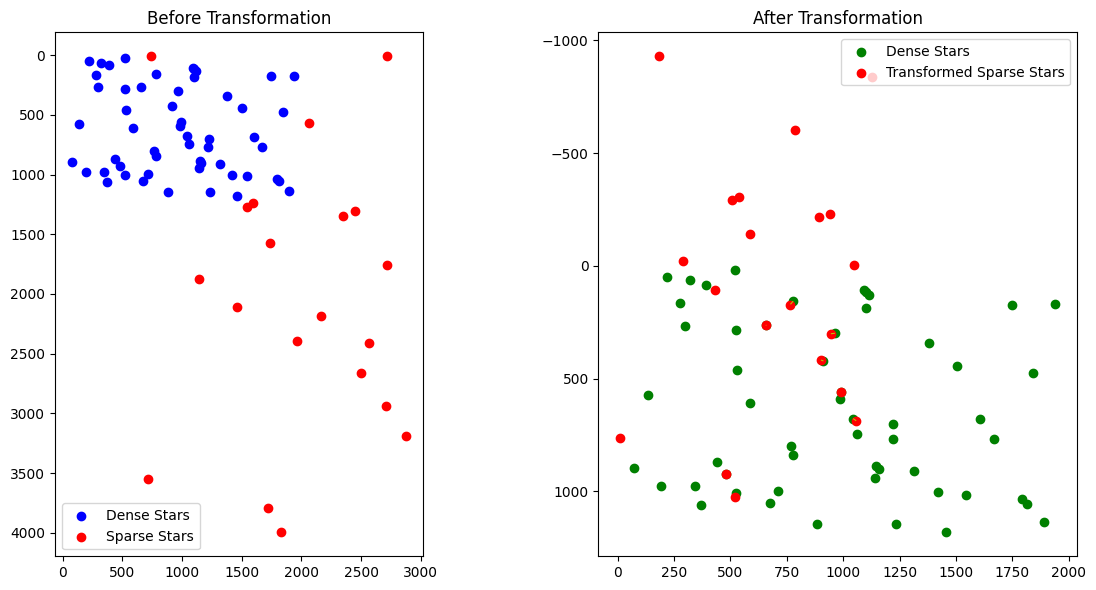

In [37]:
# Example call (assuming you still have first_img and second_img loaded)
transformed_sparse = apply_transform(
    np.array(first_img_codrs),
    transform[0], transform[1], transform[2],
    scale_radius=True)

plot_star_alignment(
    first_img_codrs,
    detect_stars(second_img_path, 2),
    transformed_sparse=transformed_sparse,
    matches=matches
)